# Housing Value and Unemployment: Is there a Correlation?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from src.cleaning import DataCleaner

In [2]:
# initialize data cleaner class, insert file paths to raw data sets
data_cleaner = DataCleaner('data/raw/hpi_po_metro.csv', 'data/raw/ssamatab1.csv')

# clean unemployment data set
clean_unemployment_data = data_cleaner.clean_unemployment_data

# clean housing data set
clean_housing_data = data_cleaner.clean_housing_data

In [3]:
# group clean_housing_data and clean_unemployment_data by year to allow the data to be joined seamlessly
grouped_housing_data = clean_housing_data.drop(columns=['Quarter','Not_Seasonally_Adjusted_Index'] ).groupby(['CBSA', 'Metro_Name', 'Year']).agg('mean').reset_index()
grouped_unemployment_data = clean_unemployment_data.drop(columns="Month").groupby(['LAUS_Code','State_FIPS_Code','FIPS_Code','Area','Year']).agg('mean').round(2).reset_index()

# move the decimal on the Unemployment_Rate column
grouped_unemployment_data["Unemployment_Rate"] = grouped_unemployment_data["Unemployment_Rate"] / 10

In [4]:
# make SQL database with tables "Unemployment" and "Housing_value"
with sqlite3.connect("database.db") as conn:
    grouped_unemployment_data.to_sql(
        "Unemployment", 
        conn, 
        if_exists='replace', 
        index=False
        )
    grouped_housing_data.to_sql(
        "Housing_Value", 
        conn, 
        if_exists='replace', 
        index=False
        )

In [5]:
# SQL query that joins the two tables Unemployment and Housing_value on the CBSA/FIPS code 
tables_unemployment_and_housing_value_joined = """

SELECT 
    Unemployment.LAUS_Code,
    Unemployment.Year,
    Unemployment.Area,
    Unemployment.Employment,
    Unemployment.Unemployment,
    Unemployment.Unemployment_Rate,
    Housing_Value.Metro_Name,
    Housing_Value.Seasonally_Adjusted_Index
FROM Unemployment
INNER JOIN Housing_Value
    ON Unemployment.FIPS_Code = Housing_Value.CBSA
    AND Unemployment.Year = Housing_Value.Year
;
    
"""

tables_unemployment_and_housing_value_joined_result = pd.read_sql(tables_unemployment_and_housing_value_joined, conn)

In [6]:
# group the combined table by area, returning the metro name, unemployment rate, and seasonally adjusted index.
tables_unemployment_and_housing_value_joined_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"])[["Unemployment_Rate", "Seasonally_Adjusted_Index"]].mean().round(2).reset_index()

# find the correlation by area
correlations_table_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"]).apply(
        lambda x: x["Unemployment_Rate"].corr(x["Seasonally_Adjusted_Index"]).round(2)
).rename("Correlation").reset_index()

/var/folders/x8/xnz6xf_x07z_kh3c75znshbc0000gn/T/ipykernel_12502/2472756190.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_table_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"]).apply(


In [7]:
# insert these two dataframes into database.db
with sqlite3.connect("database.db") as conn:
    tables_unemployment_and_housing_value_joined_grouped_by_area.to_sql(
        name="Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area",
        con=conn, 
        if_exists="replace"
        )
    correlations_table_grouped_by_area.to_sql(
        name="Correlations_by_Metro_Area",
        con=conn,
        if_exists="replace"
        )

In [8]:
# SQL query to merge the tables "Unemployment_Rate_and_SAI_by_Metro_Area and Correlations_by_Metro_Area."
unemployment_rate_and_seasonally_adusted_index_joined_to_correlations = """

SELECT
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Metro_Name,
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Unemployment_Rate,
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Seasonally_Adjusted_Index,
    Correlations_by_Metro_Area.Correlation
FROM Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area
LEFT JOIN Correlations_by_Metro_Area
    ON Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Metro_Name = Correlations_by_Metro_Area.Metro_Name
ORDER BY Correlations_by_Metro_Area.Correlation DESC
;

"""

unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result = pd.read_sql(unemployment_rate_and_seasonally_adusted_index_joined_to_correlations, conn)

In [9]:
four_cities_query = """

SELECT
    Unemployment.Year,
    Unemployment.Employment,
    Unemployment.Unemployment,
    ROUND(Unemployment.Unemployment_Rate, 2) AS Unemployment_Rate,
    Housing_Value.Metro_Name,
    ROUND(Housing_Value.Seasonally_Adjusted_Index, 2) AS Housing_Value_SAI
FROM Unemployment
INNER JOIN Housing_Value
    ON Unemployment.FIPS_Code = Housing_Value.CBSA
    AND Unemployment.Year = Housing_Value.Year
WHERE Housing_Value.Metro_Name 
    IN (
        "Fresno, CA", 
        "Des Moines-West Des Moines, IA",
        "Tulsa, OK",
        "Louisville/Jefferson County, KY-IN"
    )
;

"""
four_cities_query_result = pd.read_sql(four_cities_query, conn)

# National Correlation

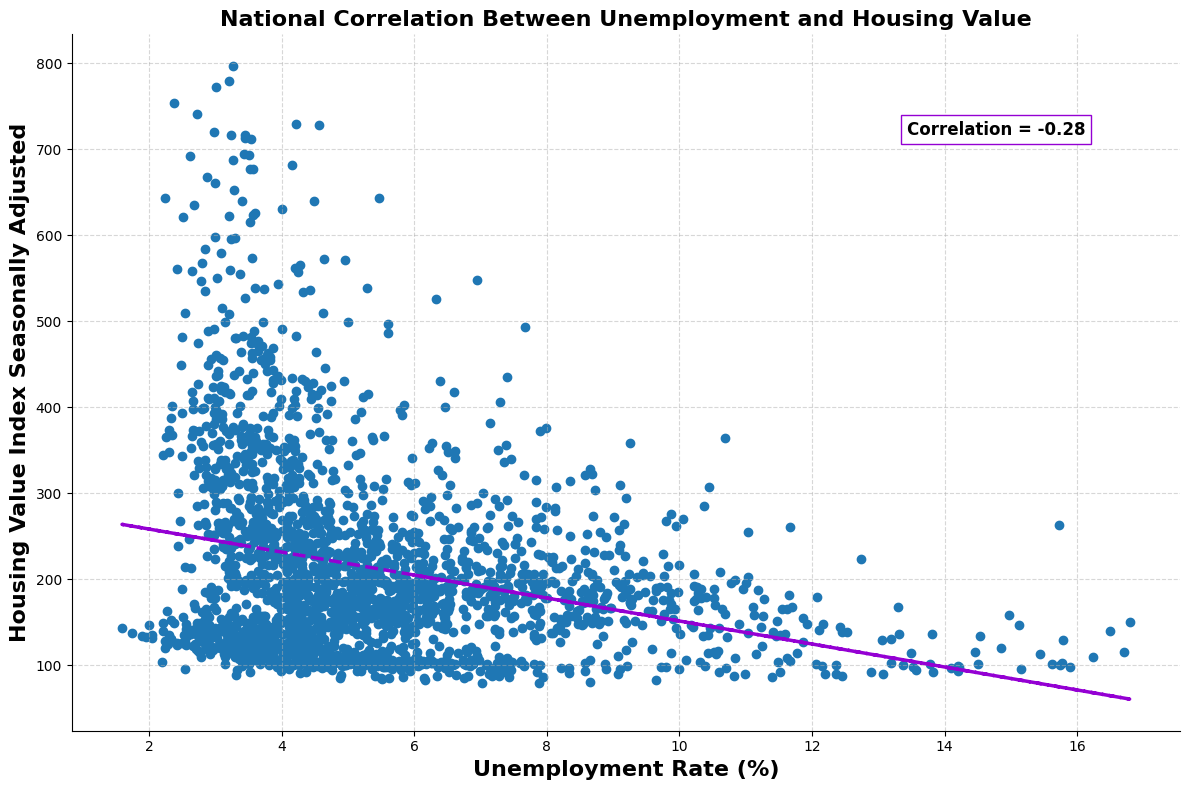

In [50]:
x = tables_unemployment_and_housing_value_joined_result['Unemployment_Rate']
y = tables_unemployment_and_housing_value_joined_result['Seasonally_Adjusted_Index']

correlation = x.corr(y).round(2)
slope, intercept = np.polyfit(x, y, 1)
y_fit = (slope * x) + intercept

fig, ax = plt.subplots(figsize=(12,8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Unemployment Rate (%)", fontweight='bold', fontsize=16)
ax.set_ylabel("Housing Value Index Seasonally Adjusted",fontweight='bold', fontsize=16)
ax.set_title("National Correlation Between Unemployment and Housing Value", fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)
ax.plot(x, y_fit, color="darkviolet", linewidth=2.5, linestyle="--")
ax.text(
    x.max() * 0.80,
    y.max() * 0.90, 
    f'Correlation = {correlation}',
    fontweight="bold", 
    fontsize=12,
    bbox={'facecolor': 'white', 'edgecolor': 'darkviolet'}
    )

sc = ax.scatter(x,y)
plt.tight_layout()
plt.show()

# Is the Negative Correlation Stronger in Certain Metro Areas?

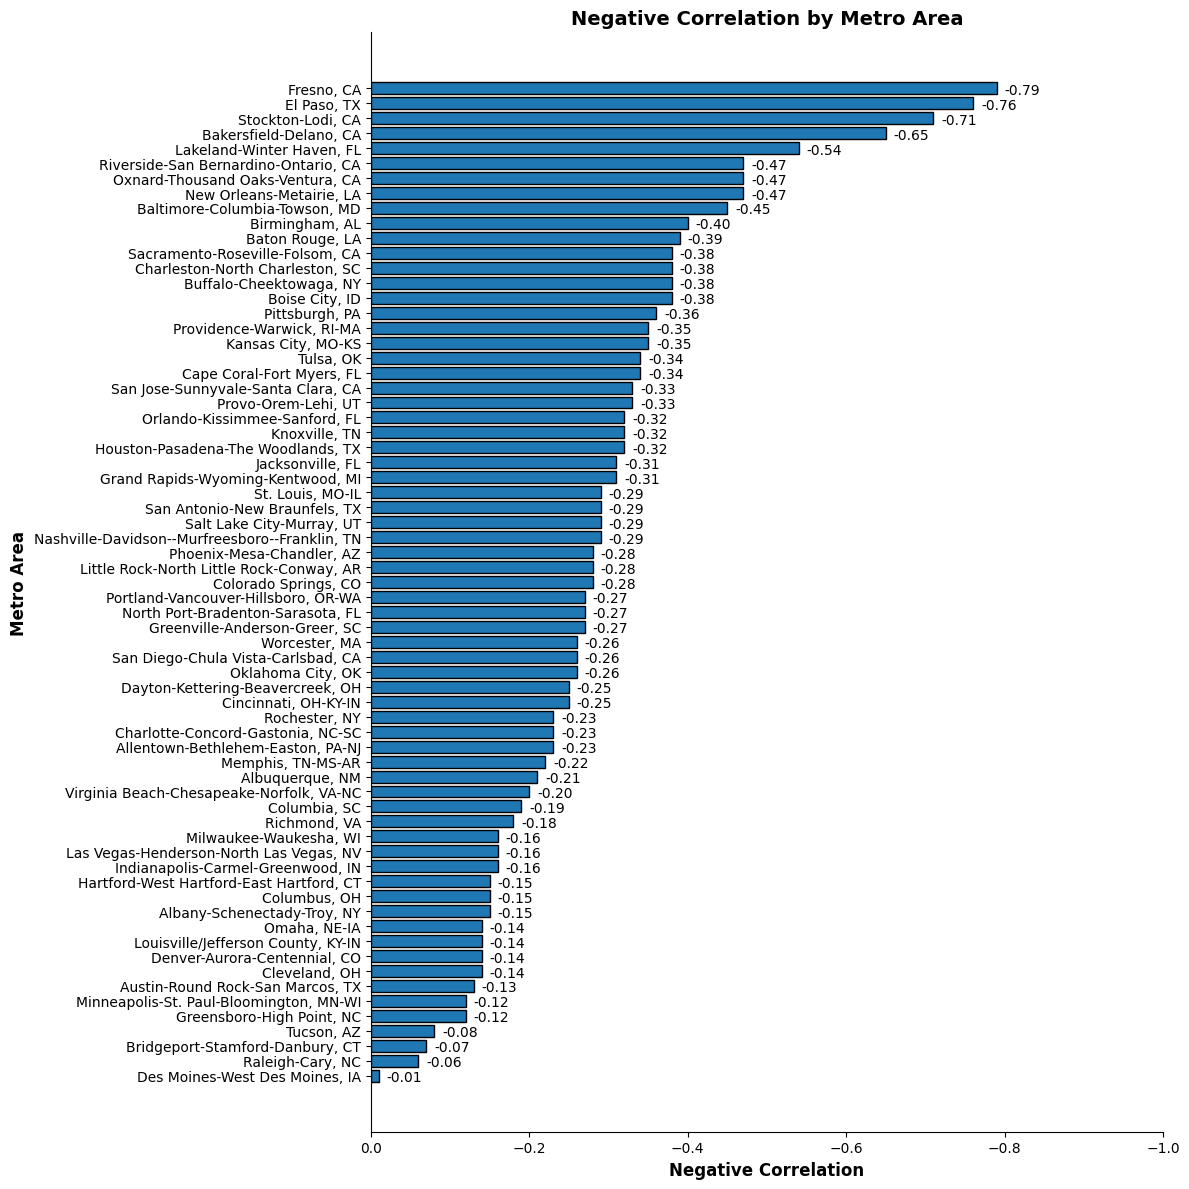

In [11]:
x = unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result["Metro_Name"]
y = unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result["Correlation"]

fig, ax = plt.subplots(figsize=(12,12))

# set the title, spine visibility, and axis labels
ax.set_title("Negative Correlation by Metro Area", fontweight="bold", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Negative Correlation", fontweight="bold", fontsize=12)
ax.set_ylabel("Metro Area", fontweight="bold", fontsize=12)
ax.set_xlim(0 , -1)

# plot as a horizontal bar chart
bars = plt.barh(x,y, edgecolor="black")

# Used a for loop to get the correlation values and place them just to the right of the bar. 
for bar in bars:
    value = bar.get_width()
    ax.text(x=value - 0.01, y=(bar.get_y() + bar.get_height() - 0.50),s=f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Time Series Analysis of Four Metros

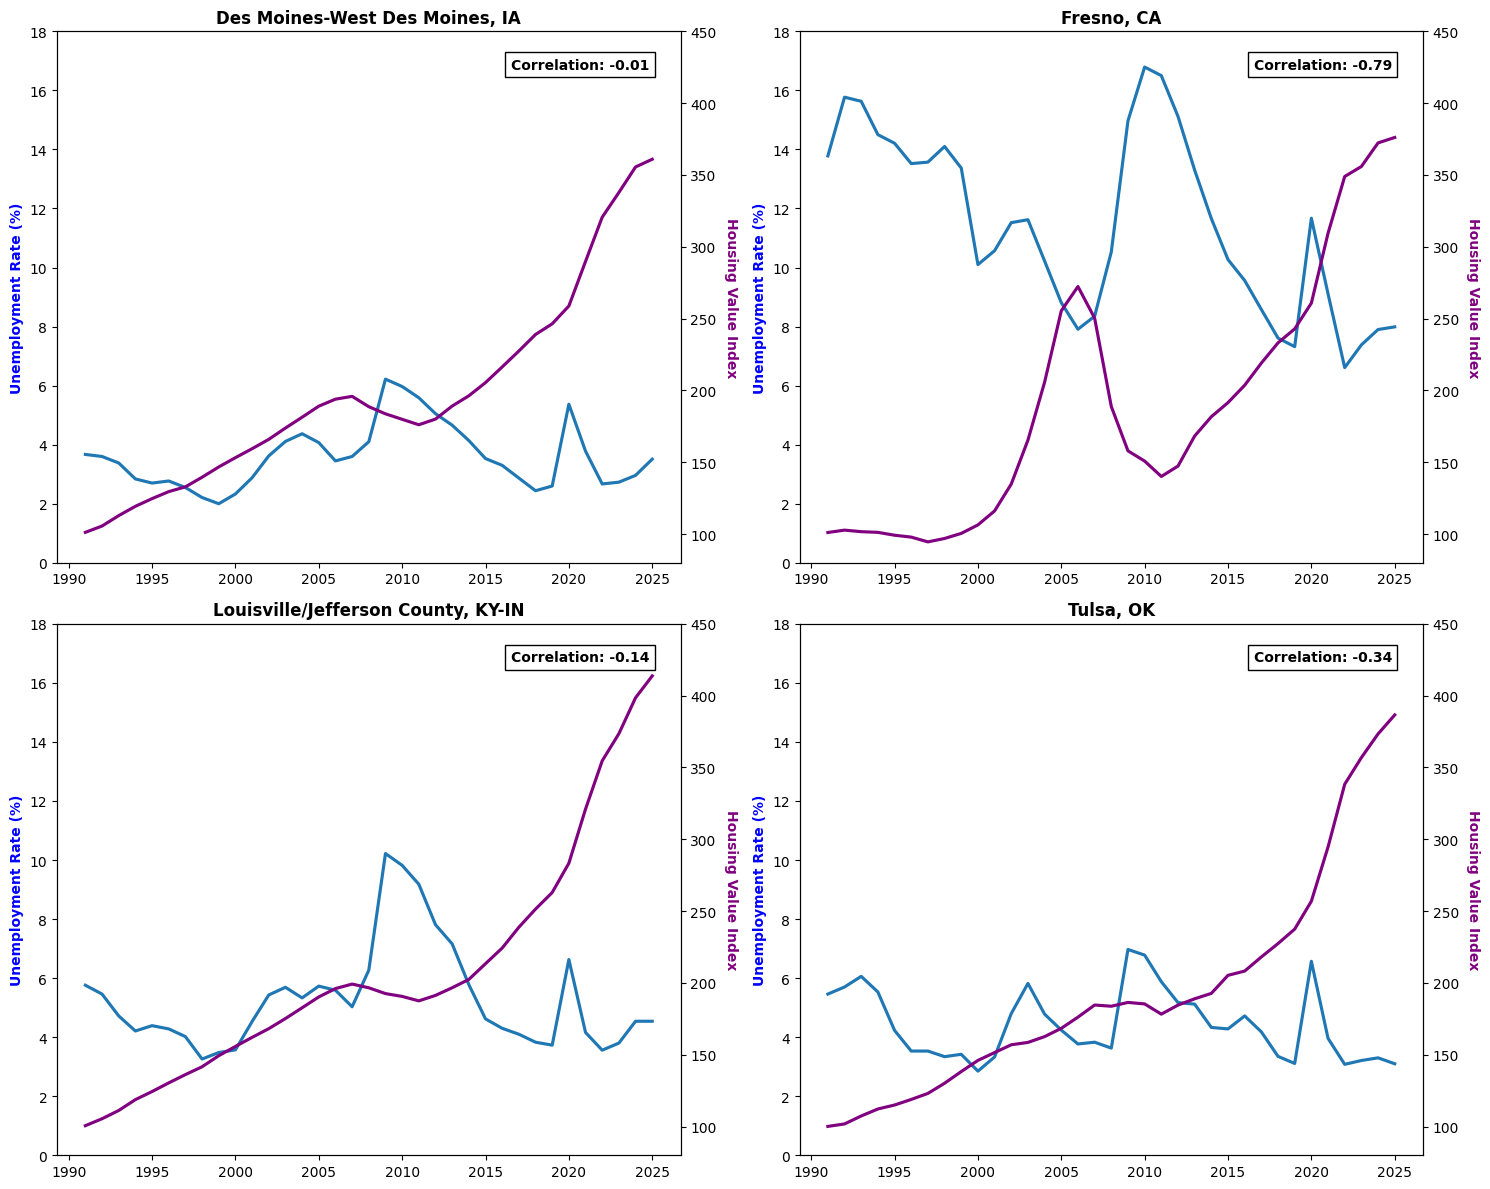

In [ ]:
# create four graphs
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# flatten to 1-D list for looping
ax = ax.flatten()

metro_names = four_cities_query_result["Metro_Name"].unique()

for metro, ax in zip(metro_names, ax):
    metro_data = four_cities_query_result[four_cities_query_result["Metro_Name"] == metro]
    
    # calculate the correlation for the title
    correlation = metro_data["Unemployment_Rate"].corr(metro_data["Housing_Value_SAI"]).round(2)
    
    # plot the left axis, which is the unemployment rate
    ax.plot(
        metro_data["Year"],
        metro_data["Unemployment_Rate"],
        linewidth=2.25
        )
    ax.set_ylabel("Unemployment Rate (%)", fontweight="bold", fontsize=10, color="blue")
    ax.set_title(f"{metro}", fontweight="bold")
    ax.set_ylim(0,18)
    ax.text(
        x=0.95,
        y=0.95,
        s=f"Correlation: {correlation}",
        fontweight="bold",
        fontsize=10,
        ha="right",
        va="top",
        bbox={'facecolor' : 'white'},
        transform=ax.transAxes      # transforms the coordinate system to be relative to the current subplot
        )
    # plot the right axis, which is. the housing value index
    ax2 = ax.twinx()
    ax2.plot(
        metro_data["Year"],
        metro_data["Housing_Value_SAI"],
        color='purple',
        linewidth=2.25
        )
    ax2.set_ylabel("Housing Value Index", fontweight="bold", rotation=270, labelpad=15, fontsize=10, color="purple")
    ax2.set_ylim(80,450)
    
    
    
plt.tight_layout()    
plt.show()

